## Steer Function Comparison
In this notebook, we examine the planners using different steer functions.

In [4]:
%load_ext autoreload
%autoreload 2
from mpb import MPB, MultipleMPB
from plot_stats import plot_planner_stats, plot_smoother_stats
from utils import latexify
from table import latex_table
from definitions import *
import matplotlib as mpl
import sys, os
mpl.rcParams['mathtext.fontset'] = 'cm'
# make sure to not use Level-3 fonts
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from copy import deepcopy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Polygon Environments

In [5]:
def benchmark_polygon(scenario: str, start: {str: float}, goal: {str: float}):
    time_limit_multiplier = 1
    bench = "polygon_%s" % scenario

    steer_function_times = [
        ('reeds_shepp', 15 * time_limit_multiplier),    
        ('dubins', 45 * time_limit_multiplier),    
        ('cc_reeds_shepp', 1.5 * 60 * time_limit_multiplier),    
        ('posq', 120 * time_limit_multiplier)
    ]
    
    pool = MultipleMPB()
    # config = MPB.get_config()
    for steer_function, time_limit in steer_function_times:
        m = MPB()   
        # m.update(deepcopy(config))
        m["max_planning_time"] = time_limit
        m["env.start"] = start
        m["env.goal"] = goal
        m["env.type"] = "polygon"
        m["env.polygon.source"] = "polygon_mazes/%s.svg" % scenario
        m["benchmark.planning.sbpl_adstar"] = False
        m["benchmark.planning.sbpl_anastar"] = False
        m["benchmark.planning.sbpl_arastar"] = False
        m["benchmark.planning.sbpl_lazy_ara"] = False
        m["benchmark.planning.sbpl_mha"] = False
        m.set_steer_functions([steer_function])
        #     m.set_smoothers(['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max'])
        #     m.set_planners(['theta_star'])
        #     m.set_planners(['sbpl_adstar'])
        pool.benchmarks.append(m)
    run_result = pool.run_parallel(bench, processes=20, limit_memory=True)

    for i, (steer_function, _) in enumerate(steer_function_times):
        bench_steer = "%s_%s" % (bench, steer_function)
        # plot trajectories
        try:
            pool.benchmarks[i].visualize_trajectories(show_legend=True, fig_width=8, fig_height=8)
            plt.savefig("%s/%s_trajectories.pdf" % (bench, bench_steer), bbox_inches='tight')
        except Exception as e:
            print("Error while visualizing trajectories:", e, file=sys.stderr)

        # plot planner stats
        try:        
            plot_planner_stats(pool.benchmarks[i].results_filename, save_file="%s/%s_stats.pdf" % (bench, bench_steer))
        except Exception as e:
            print("Error while plotting planner statistics:", e, file=sys.stderr)

        # plot smoother stats
        try:
            plot_smoother_stats(pool.benchmarks[i].results_filename,
                                save_file="%s/%s_smoother_stats.pdf" % (bench, bench_steer),
                                separate_planners=False, num_colors=8,
                                combine_views=True, max_plots_per_line=3)
        except Exception as e:
            print("Error while plotting smoother statistics:", e, file=sys.stderr)

        # plot smoother stats (separated by planners)
        try:
            plot_smoother_stats(pool.benchmarks[i].results_filename,
                                save_file="%s/%s_smoother_stats_separated.pdf" % (bench, bench_steer),
                                separate_planners=True, num_colors=8, combine_views=True,
                                max_plots_per_line=1, fig_width=25, fig_height=6)
        except Exception as e:
            print("Error while plotting smoother statistics:", e, file=sys.stderr)

        # generate LaTeX table
        try:
            with open("%s/%s_table.txt" % (bench, bench_steer), 'w') as tf:
                tf.write(latex_table(pool.benchmarks[i].results_filename,
                                     row_label='\\textbf{Steer function: \\texttt{%s}} (\\SI{%.1f}{\\minute} time limit)'

                                     % (latexify(steer_function_names[steer_function]),
                                        time_limit/60),
                                     time_limit=time_limit))
        except Exception as e:
            print("Error while generating table:", e, file=sys.stderr)

        return run_result

Created MPB from config ../bin/benchmark_template.json.
Created MPB from config ../bin/benchmark_template.json.
Created MPB from config ../bin/benchmark_template.json.
Created MPB from config ../bin/benchmark_template.json.
Available memory: 229.49 GB, limiting each MPB process to 6.9% usage (15.94 GB).
Creating pool of 4 processes.
Created MPB from config polygon_parking1/polygon_parking1_0_config.json.
Created MPB from config polygon_parking1/polygon_parking1_1_config.json.
Created MPB from config polygon_parking1/polygon_parking1_2_config.json.
Created MPB from config polygon_parking1/polygon_parking1_3_config.json.
Running MPB with ID polygon_parking1_0 (log file at polygon_parking1/polygon_parking1_0.log)...
Running MPB with ID polygon_parking1_1 (log file at polygon_parking1/polygon_parking1_1.log)...
Running MPB with ID polygon_parking1_3 (log file at polygon_parking1/polygon_parking1_3.log)...
Running MPB with ID polygon_parking1_2 (log file at polygon_parking1/polygon_parking1


Benchmark 0 (polygon_parking1_0) finished successfully.

Benchmark 3 (polygon_parking1_3) finished successfully.

Benchmark 2 (polygon_parking1_2) finished successfully.

Benchmark 1 (polygon_parking1_1) finished successfully.
All benchmarks succeeded.
Visualizing polygon_parking1/polygon_parking1_0_results.json
Planner Theta* found no solution!


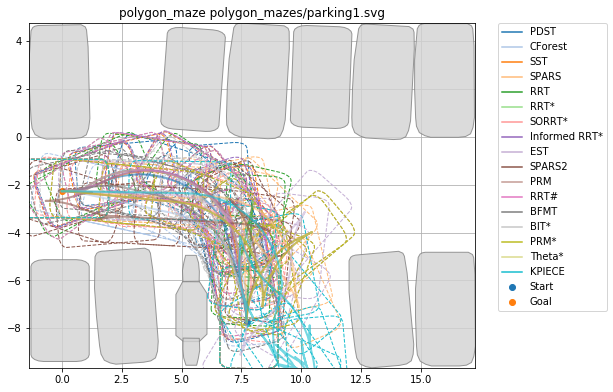

Visualizing polygon_parking1/polygon_parking1_0_results.json...


/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py:2093: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3400: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


Saved polygon_parking1/polygon_parking1_reeds_shepp_stats.pdf.


<Figure size 432x288 with 0 Axes>

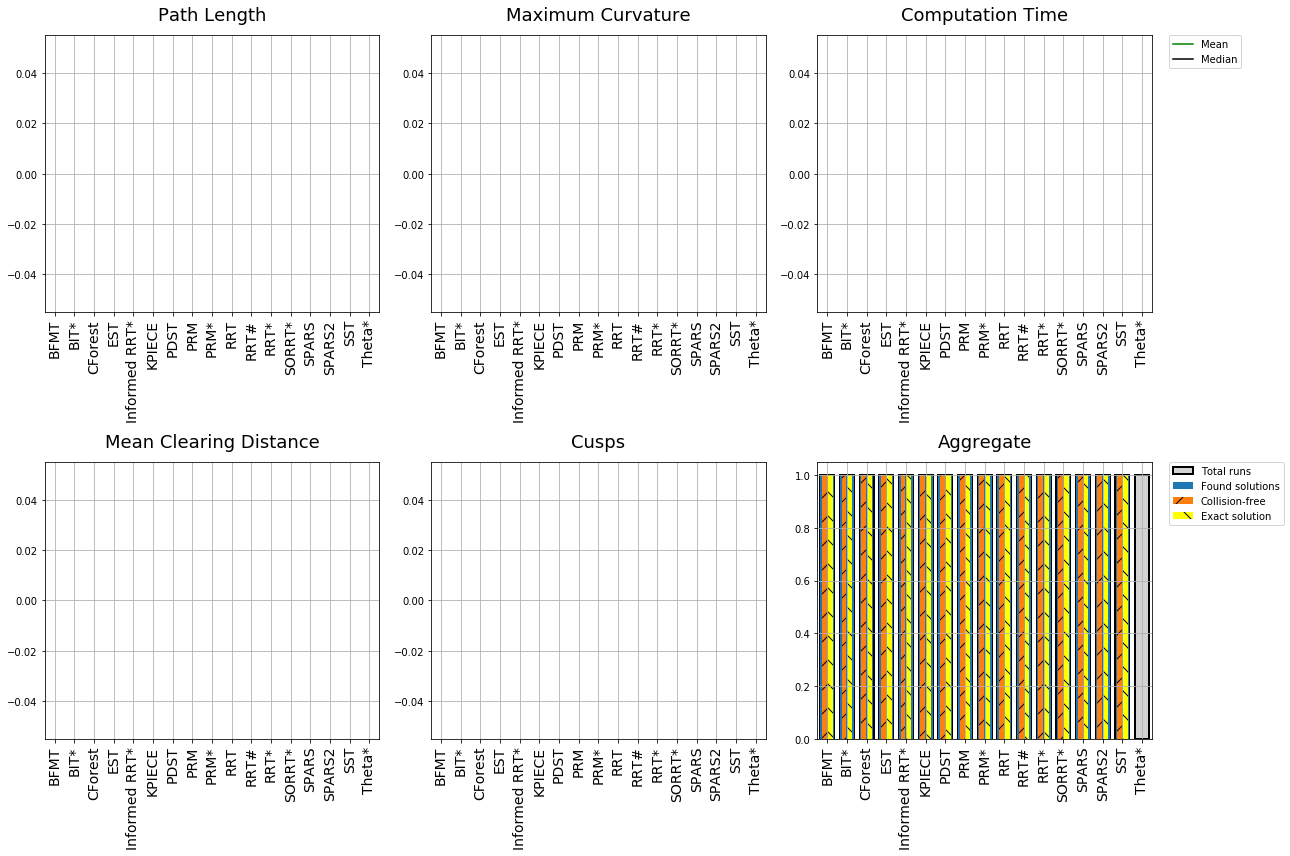

Visualizing polygon_parking1/polygon_parking1_0_results.json...
Visualizing polygon_parking1/polygon_parking1_0_results.json...
Created MPB from config ../bin/benchmark_template.json.
Created MPB from config ../bin/benchmark_template.json.
Created MPB from config ../bin/benchmark_template.json.
Created MPB from config ../bin/benchmark_template.json.
Available memory: 228.88 GB, limiting each MPB process to 6.9% usage (15.89 GB).
Creating pool of 4 processes.


Error while plotting smoother statistics: 'NoneType' object has no attribute 'items'
Error while plotting smoother statistics: 'NoneType' object has no attribute 'items'


Created MPB from config polygon_parking2/polygon_parking2_3_config.json.
Created MPB from config polygon_parking2/polygon_parking2_2_config.json.
Created MPB from config polygon_parking2/polygon_parking2_0_config.json.
Created MPB from config polygon_parking2/polygon_parking2_1_config.json.
Running MPB with ID polygon_parking2_3 (log file at polygon_parking2/polygon_parking2_3.log)...
Running MPB with ID polygon_parking2_2 (log file at polygon_parking2/polygon_parking2_2.log)...
Running MPB with ID polygon_parking2_0 (log file at polygon_parking2/polygon_parking2_0.log)...
Running MPB with ID polygon_parking2_1 (log file at polygon_parking2/polygon_parking2_1.log)...



Benchmark 0 (polygon_parking2_0) finished successfully.

Benchmark 1 (polygon_parking2_1) finished successfully.

Benchmark 3 (polygon_parking2_3) finished successfully.

Benchmark 2 (polygon_parking2_2) finished successfully.
All benchmarks succeeded.
Visualizing polygon_parking2/polygon_parking2_0_results.json
Planner Theta* found no solution!


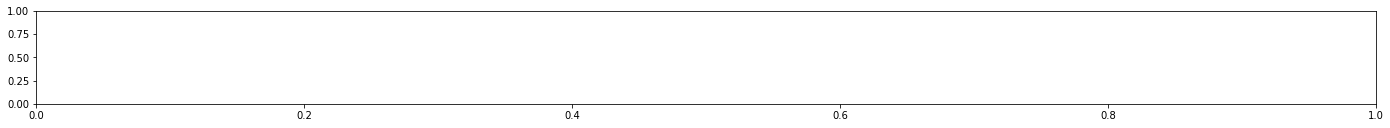

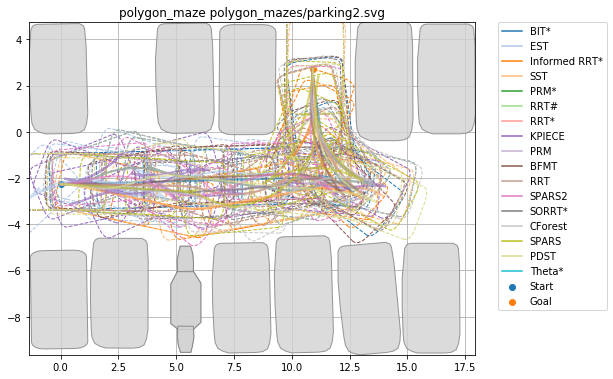

Visualizing polygon_parking2/polygon_parking2_0_results.json...
Saved polygon_parking2/polygon_parking2_reeds_shepp_stats.pdf.


<Figure size 432x288 with 0 Axes>

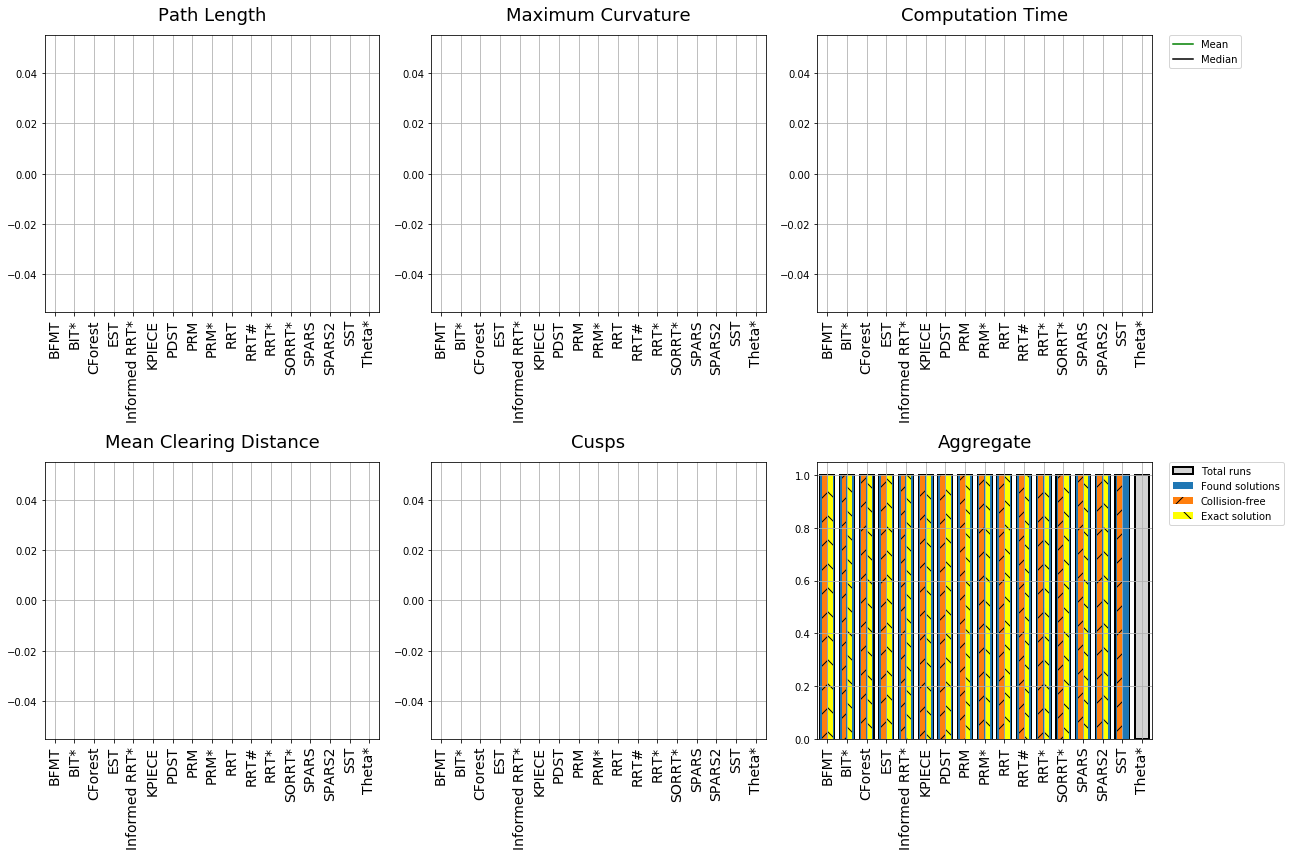

Visualizing polygon_parking2/polygon_parking2_0_results.json...
Visualizing polygon_parking2/polygon_parking2_0_results.json...
Created MPB from config ../bin/benchmark_template.json.
Created MPB from config ../bin/benchmark_template.json.
Created MPB from config ../bin/benchmark_template.json.
Created MPB from config ../bin/benchmark_template.json.
Available memory: 230.59 GB, limiting each MPB process to 6.9% usage (16.01 GB).
Creating pool of 4 processes.


Error while plotting smoother statistics: 'NoneType' object has no attribute 'items'
Error while plotting smoother statistics: 'NoneType' object has no attribute 'items'


Created MPB from config polygon_parking3/polygon_parking3_0_config.json.
Created MPB from config polygon_parking3/polygon_parking3_1_config.json.
Created MPB from config polygon_parking3/polygon_parking3_2_config.json.
Running MPB with ID polygon_parking3_2 (log file at polygon_parking3/polygon_parking3_2.log)...
Created MPB from config polygon_parking3/polygon_parking3_3_config.json.
Running MPB with ID polygon_parking3_1 (log file at polygon_parking3/polygon_parking3_1.log)...
Running MPB with ID polygon_parking3_0 (log file at polygon_parking3/polygon_parking3_0.log)...
Running MPB with ID polygon_parking3_3 (log file at polygon_parking3/polygon_parking3_3.log)...



Benchmark 0 (polygon_parking3_0) finished successfully.

Benchmark 3 (polygon_parking3_3) finished successfully.

Benchmark 1 (polygon_parking3_1) finished successfully.

Benchmark 2 (polygon_parking3_2) finished successfully.
All benchmarks succeeded.
Visualizing polygon_parking3/polygon_parking3_0_results.json
Planner SPARS found no solution!
Planner Theta* found no solution!
Planner SPARStwo found no solution!


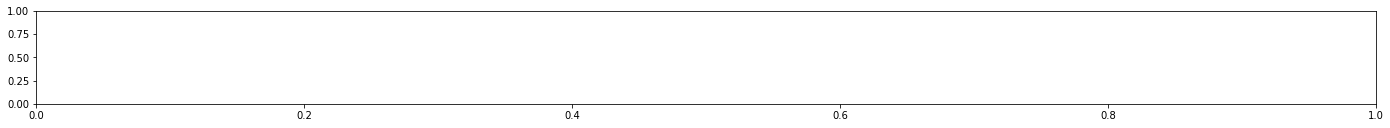

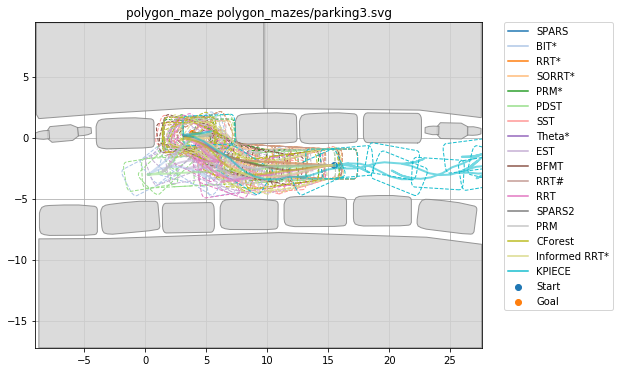

Visualizing polygon_parking3/polygon_parking3_0_results.json...
Saved polygon_parking3/polygon_parking3_reeds_shepp_stats.pdf.


<Figure size 432x288 with 0 Axes>

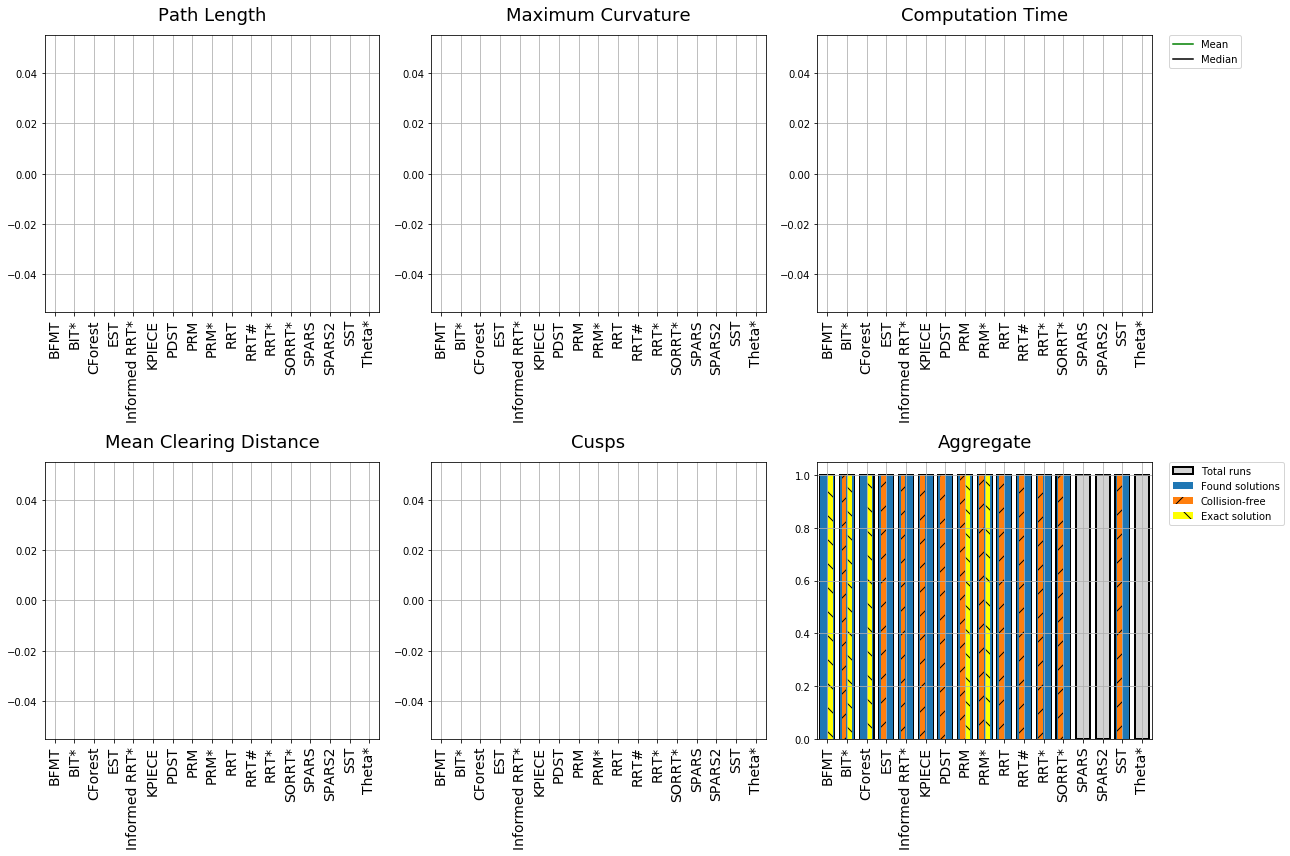

Visualizing polygon_parking3/polygon_parking3_0_results.json...
Visualizing polygon_parking3/polygon_parking3_0_results.json...
Created MPB from config ../bin/benchmark_template.json.
Created MPB from config ../bin/benchmark_template.json.
Created MPB from config ../bin/benchmark_template.json.
Created MPB from config ../bin/benchmark_template.json.
Available memory: 231.62 GB, limiting each MPB process to 6.9% usage (16.08 GB).
Creating pool of 4 processes.


Error while plotting smoother statistics: 'NoneType' object has no attribute 'items'
Error while plotting smoother statistics: 'NoneType' object has no attribute 'items'


Created MPB from config polygon_warehouse/polygon_warehouse_1_config.json.
Created MPB from config polygon_warehouse/polygon_warehouse_3_config.json.
Created MPB from config polygon_warehouse/polygon_warehouse_0_config.json.
Created MPB from config polygon_warehouse/polygon_warehouse_2_config.json.
Running MPB with ID polygon_warehouse_1 (log file at polygon_warehouse/polygon_warehouse_1.log)...
Running MPB with ID polygon_warehouse_2 (log file at polygon_warehouse/polygon_warehouse_2.log)...
Running MPB with ID polygon_warehouse_0 (log file at polygon_warehouse/polygon_warehouse_0.log)...
Running MPB with ID polygon_warehouse_3 (log file at polygon_warehouse/polygon_warehouse_3.log)...



Benchmark 0 (polygon_warehouse_0) finished successfully.

Benchmark 1 (polygon_warehouse_1) finished successfully.

Benchmark 3 (polygon_warehouse_3) finished successfully.

Benchmark 2 (polygon_warehouse_2) finished successfully.
All benchmarks succeeded.
Visualizing polygon_warehouse/polygon_warehouse_0_results.json
Planner Theta* found no solution!
Planner SPARStwo found no solution!


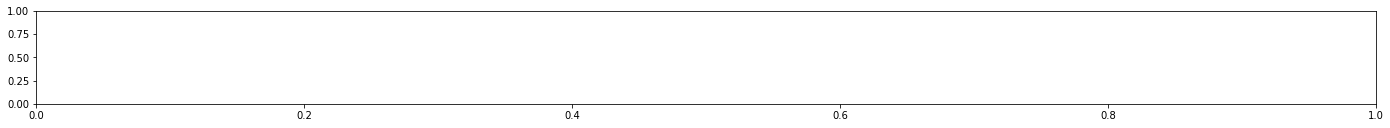

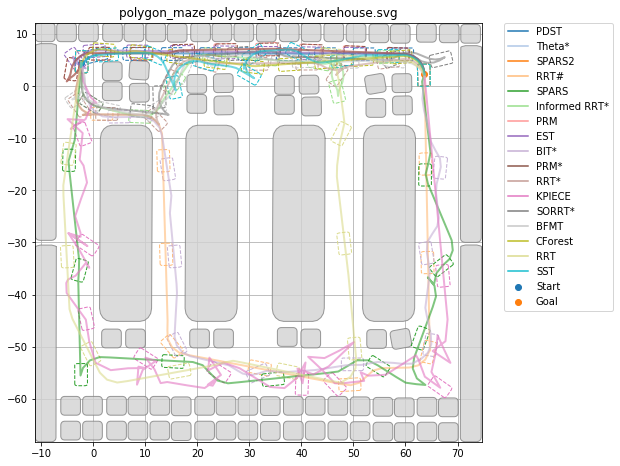

Visualizing polygon_warehouse/polygon_warehouse_0_results.json...
Saved polygon_warehouse/polygon_warehouse_reeds_shepp_stats.pdf.


<Figure size 432x288 with 0 Axes>

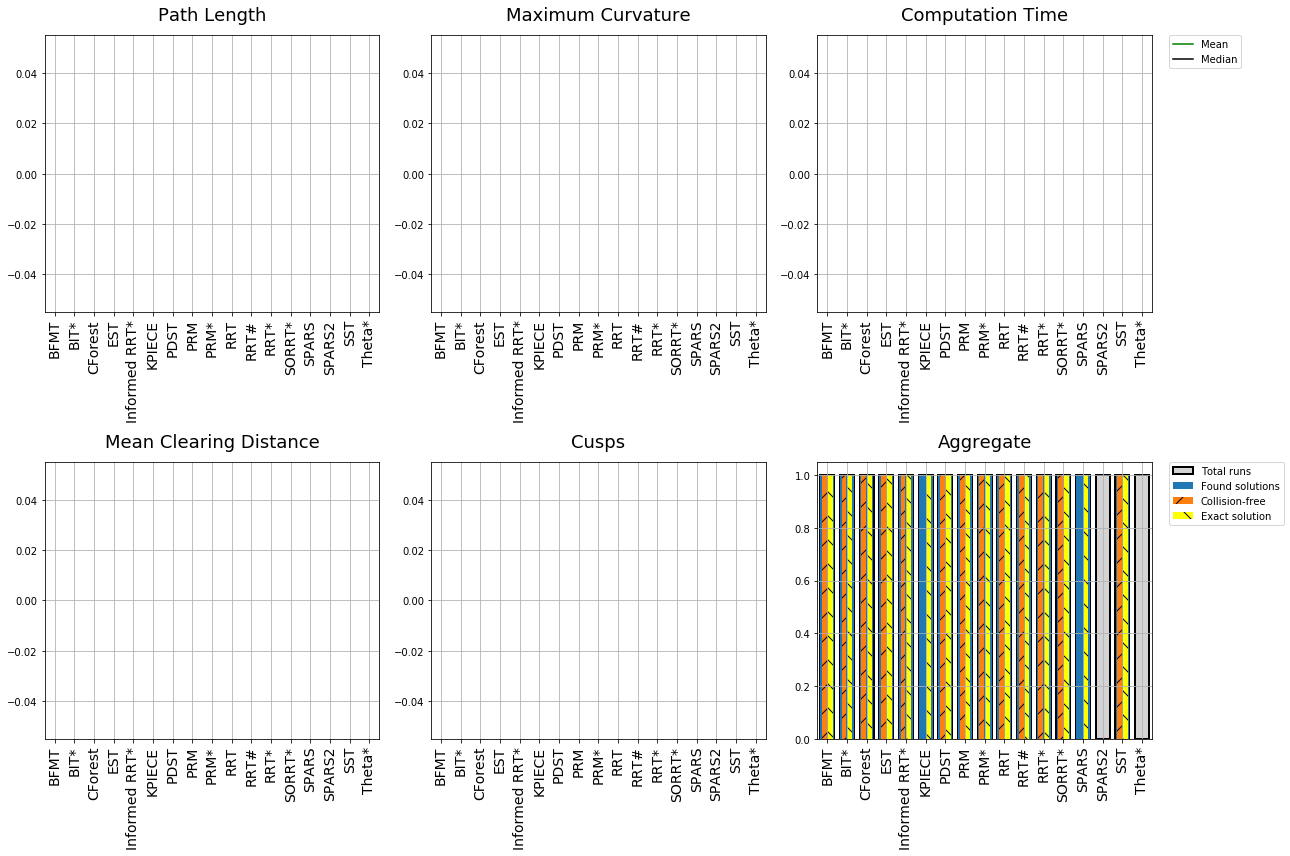

Visualizing polygon_warehouse/polygon_warehouse_0_results.json...
Visualizing polygon_warehouse/polygon_warehouse_0_results.json...


Error while plotting smoother statistics: 'NoneType' object has no attribute 'items'
Error while plotting smoother statistics: 'NoneType' object has no attribute 'items'


[True, True, True, True]

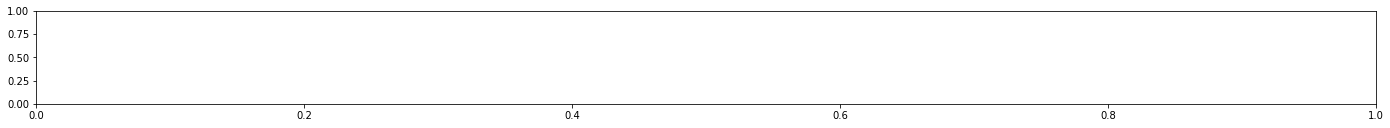

In [6]:
scenarios = [
  ("parking1", {"theta": -1.58, "x": 7.72, "y": -7.72}, {"theta": 0, "x": 0, "y": -2.27}),
  ("parking2", {"theta": 0, "x": 0, "y": -2.27}, {"theta": -1.57, "x": 10.91, "y": 2.73}),
  ("parking3", {"theta": 0, "x": 15.45, "y": -2.27}, {"theta": 0, "x": 3.82, "y": 0.34}),
  ("warehouse", {"theta": -1.58, "x": -2.27, "y": 4.55}, {"theta": 1.58, "x": 63.64, "y": 2.27})
]

list(map(lambda x: benchmark_polygon(*x), scenarios))